In [1]:
import tensorly as tl
from tensorly import decomposition
import numpy as np

In [2]:
PLUS = np.array([.5 ** .5, .5 ** .5])
GHZ = np.array([.5 ** .5, 0, 0, 0, 0, 0, 0, .5 ** .5])
BELL = np.array([.5 ** .5, 0, 0, .5 ** .5])

noise16 = (np.random.random((16,)) - .5) / 1000.0
noise32 = (np.random.random((32,)) - .5) / 1000.0
noise64 = (np.random.random((64,)) - .5) / 1000.0
noise8 = (np.random.random((8,)) - .5) / 1000.0

In [3]:
def to_state(vector):
    return vector / sum(abs(vector)) ** .5

def to_tensor(vector):
    n = int(np.log2(vector.size))
    return vector.reshape([2] * n)

In [4]:
GHZ_ = to_state(GHZ + noise8)
BELL_PLUS = to_state(np.kron(BELL, PLUS) + noise8)
BELL_BELL = to_state(np.kron(BELL, BELL) + noise16)
PLUS_GHZ = to_state(np.kron(PLUS, GHZ) + noise16)
GHZ_PLUS = to_state(np.kron(GHZ, PLUS) + noise16)
GHZ_BELL = to_state(np.kron(GHZ, BELL) + noise32)
BELL_GHZ = to_state(np.kron(BELL, GHZ) + noise32)
GHZ_GHZ = to_state(np.kron(GHZ, GHZ) + noise64)

In [5]:
GHZ_ = to_tensor(GHZ_)
BELL_PLUS = to_tensor(BELL_PLUS)
BELL_BELL = to_tensor(BELL_BELL)
PLUS_GHZ = to_tensor(PLUS_GHZ)
GHZ_PLUS = to_tensor(GHZ_PLUS)
GHZ_BELL = to_tensor(GHZ_BELL)
BELL_GHZ = to_tensor(BELL_GHZ)
GHZ_GHZ = to_tensor(GHZ_GHZ)
G_PLUS_HZ = tl.moveaxis(PLUS_GHZ.copy(), [0, 1, 2, 3], [1, 0, 2, 3])
GH_PLUS_Z = tl.moveaxis(GHZ_PLUS.copy(), [0, 1, 2, 3], [0, 1, 3, 2])

In [6]:
def get_singular_sum(tensor):
    import itertools
    from collections import Counter
    core, matrices = tl.decomposition.tucker(tensor, rank=tensor.shape)
    result = Counter()
    for index in itertools.product([0, 1], repeat=tensor.ndim):
        for i, v in enumerate(index):
            if v == 1: 
                result[i] += abs(core[index])
    return result.most_common()[::-1]

In [7]:
print(get_singular_sum(PLUS_GHZ))
print(get_singular_sum(GHZ_PLUS))
print(get_singular_sum(G_PLUS_HZ))
print(get_singular_sum(GH_PLUS_Z))

[(0, 0.0016230791796551466), (3, 0.7937914339010752), (2, 0.7996046970411729), (1, 0.8303123270849451)]
[(3, 0.0008881589903181157), (2, 0.7802071332348177), (0, 0.7954247692669874), (1, 0.8176675405857983)]
[(1, 0.0016230791796549987), (3, 0.7937914339010745), (2, 0.7996046970411553), (0, 0.830312327084943)]
[(2, 0.0008881589903177198), (3, 0.780207133234927), (0, 0.7954247692670728), (1, 0.8176675405859024)]


In [8]:
get_singular_sum(BELL_BELL) # does not work as good as for a single qubit

[(0, 0.7064486579664196),
 (3, 0.7067934422070685),
 (1, 0.7069398569079268),
 (2, 0.7070620128295165)]

In [9]:
def to_plot(data):
    d = [x[1] for x in data]
    l = [x[0] for x in data]
    return d, l

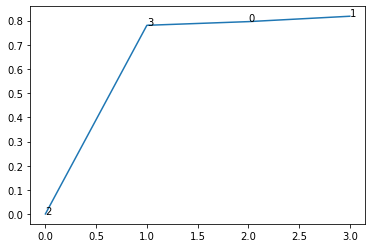

In [10]:
import matplotlib.pyplot as plt
data, labels = to_plot(get_singular_sum(GH_PLUS_Z))
plt.plot(data)
for i, label in enumerate(labels):
    plt.annotate(str(label), (i, data[i]))

# Rolling the Bell-Bell tensor

In [11]:
core, matrices = tl.decomposition.tucker(BELL_BELL, rank=BELL_BELL.shape)

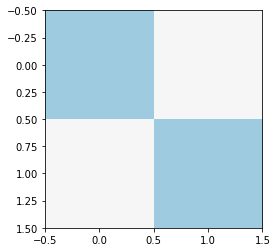

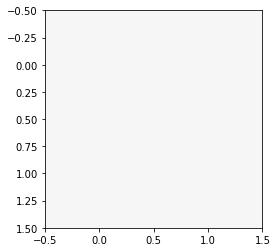

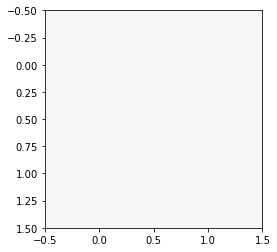

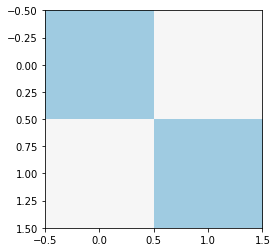

In [12]:
for i in range(4):
    plt.imshow(core.reshape(2, 2, -1)[:, :, i], vmax=1, vmin=-1, cmap="RdBu")
    plt.show()

# Hypothesis test

In [13]:
def get_singular_group_sum(tensor, k=2):
    import itertools
    from collections import Counter
    core, matrices = tl.decomposition.tucker(tensor, rank=tensor.shape)
    result = Counter()
    for index in itertools.product([0, 1], repeat=len(tensor.shape)):
        value = core[index]
        for subindex in itertools.product([0, 1], repeat=k):
            for pair in itertools.combinations(range(len(tensor.shape)), r=k):
                tpl = tuple(subindex + pair)
                if all(index[pair[i]] == subindex[i] for i in range(k)):
                    result[tpl] += abs(value)
            
    return result.most_common()[::-1]

In [14]:
get_singular_group_sum(GHZ_BELL, k=3)

[((0, 1, 0, 2, 3, 4), 0.0003424370814304064),
 ((0, 0, 1, 1, 3, 4), 0.00037869900474348265),
 ((1, 0, 1, 2, 3, 4), 0.0003989204425747573),
 ((1, 0, 1, 0, 3, 4), 0.000428878978302552),
 ((1, 1, 0, 1, 3, 4), 0.0004771699641930704),
 ((0, 0, 1, 0, 3, 4), 0.0004985319700486052),
 ((0, 0, 1, 2, 3, 4), 0.0005284905057763999),
 ((1, 0, 1, 1, 3, 4), 0.0005487119436076745),
 ((1, 1, 0, 0, 3, 4), 0.0005596947634013472),
 ((0, 1, 0, 0, 3, 4), 0.0007192400271342882),
 ((0, 1, 0, 1, 3, 4), 0.0008017648263425651),
 ((1, 1, 0, 2, 3, 4), 0.0009364977091052291),
 ((1, 0, 1, 0, 1, 2), 0.02188593970779415),
 ((1, 0, 1, 0, 1, 4), 0.046707440720086174),
 ((1, 0, 0, 0, 1, 3), 0.04683157736874978),
 ((1, 0, 1, 0, 1, 3), 0.0468488055585945),
 ((1, 0, 0, 0, 1, 4), 0.046972942207258096),
 ((0, 1, 0, 0, 1, 2), 0.049482770775784356),
 ((0, 1, 1, 0, 1, 3), 0.0529731296255303),
 ((0, 1, 1, 0, 1, 4), 0.053034122551535376),
 ((0, 1, 0, 0, 1, 4), 0.05320790620254799),
 ((0, 1, 0, 0, 1, 3), 0.053268899128553066),
 ((0,